## Load Data From Pickles

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import re

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
all_tweets_training = pd.read_pickle("saved_pickles/all_tweets_training.pkl")
all_tweets_validation = pd.read_pickle("saved_pickles/all_tweets_validation.pkl")

# Perform LSA on Training Set and Transform Testing Set

In [4]:
from lsa import lsa_pipeline
from lsa import run_lsa

In [5]:
all_tweets_training_lsa, vectorizer, svd = lsa_pipeline(all_tweets_training, min_df= 0.001,
                                                        max_df=0.5, num_components=200)

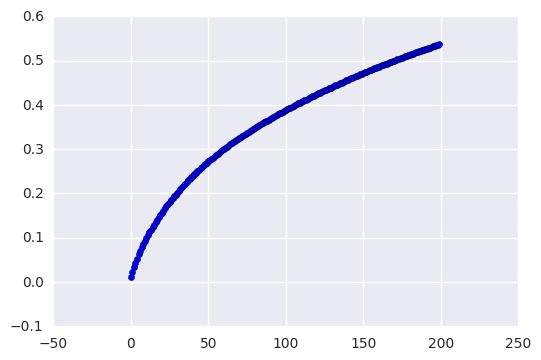

In [6]:
exp_var = svd.explained_variance_ratio_

plt.scatter(x=range(len(exp_var)), y=[sum(exp_var[:i+1]) for i in range(len(exp_var))])

In [7]:
all_tweets_validation_lsa = run_lsa(all_tweets_validation, vectorizer, svd)

In [9]:
from sklearn.externals import joblib

joblib.dump(vectorizer, "saved_pickles/lsa_vectorizer.pkl")
joblib.dump(svd, "saved_pickles/lsa_svd.pkl")
joblib.dump(all_tweets_training_lsa, "saved_pickles/all_tweets_training_lsa.pkl")
joblib.dump(all_tweets_validation_lsa, "saved_pickles/all_tweets_validation_lsa.pkl")

['all_tweets_validation_lsa.pkl']

# Perform Binary Classification on Video Games vs. Unrelated Tweets

In [8]:
from classification import default_model_set
from classification import grid_search_model

In [9]:
model_set = default_model_set()

In [10]:
X = all_tweets_training_lsa
y = all_tweets_training["game_related_tweet"]

In [11]:
model_results = grid_search_model(model_set, X, y)

K-Nearest Neighbors
{'Standard Scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'Name': 'K-Nearest Neighbors', 'Best_Estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance'), 'Score': 0.86257142857142854, 'Grid': GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance'),
       fit_params={}, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0), 'Test Score': 0.8666666666666667}
Logistic Regression
{'Standard Scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'Name': 'Logistic Regression', 'Best_Estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
   

In [2]:
model_results.to_pickle("saved_pickles/simple_model_grid_binary_video_game_classification.pkl")

NameError: name 'model_results' is not defined

In [6]:
model_results = pd.read_pickle("saved_pickles/simple_model_grid_binary_video_game_classification.pkl")
model_results[["Name","Score","Test Score"]]

,Name,Score,Test Score
0,K-Nearest Neighbors,0.862571,0.866667
1,Logistic Regression,0.939343,0.937000
2,SVC,0.947057,0.947067
3,Decision Tree,0.932629,0.930867
4,Random Forest,0.947400,0.948467
5,Extra Trees,0.943371,0.938733


In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_params = {'criterion':['gini','entropy'], 'n_estimators':[2,5,10,20],
             'max_features':[None, 'auto', 'sqrt','log2']}

random_forest_grid = [["Random Forest", rf, rf_params]]

In [37]:
random_forest_results = grid_search_model(random_forest_grid, X, y)

Random Forest


KeyboardInterrupt: 

In [ ]:
random_forest_results.to_pickle("saved_pickles/random_forest_grid_model.pkl")

In [20]:
#random_forest_results = pd.read_pickle("saved_pickles/random_forest_grid_model.pkl")
#random_forest_results

,Best_Estimator,Grid,Name,Score,Test Score
0,"(DecisionTreeClassifier(class_weight=None, cri...","GridSearchCV(cv=5, error_score='raise',\n ...",Random Forest,0.955314,0.953867


In [21]:
best_model = model_results["Best_Estimator"].loc[4]
scaler = model_results["Standard Scaler"].loc[4]

In [23]:
validation_true = all_tweets_validation["game_related_tweet"]
validation_pred = best_model.predict(scaler.transform(all_tweets_validation_lsa))

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [25]:
from sklearn.metrics import accuracy_score

In [26]:
test = pd.DataFrame(validation_true)
test.index = range(validation_true.shape[0])

In [27]:
accuracy_score(y_true = validation_true, y_pred = validation_pred)

0.94047108318686945

In [30]:
print classification_report(y_true = validation_true, y_pred = validation_pred)

             precision    recall  f1-score   support

          0       0.92      0.98      0.95     83798
          1       0.97      0.89      0.93     60720

avg / total       0.94      0.94      0.94    144518



In [32]:
cm = confusion_matrix(y_true = validation_true, y_pred = validation_pred)

In [ ]:
names = ["Game-Related", "Unfiltered"]
sns.heatmap(cm, square=True,annot=True,fmt='d',cbar=True,
            xticklabels=names, yticklabels=names)